In [ ]:
pip install pandas matplotlib scipy numpy seaborn scikit-learn

In [1]:
import copy
import pandas
import warnings
import requests
import scipy
from scipy import stats
import subprocess
import numpy as np
from matplotlib import pyplot as plt
import json
import pprint
import seaborn
import os
import sys
from pathlib import Path

sys.path.insert(0, "../src")
from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

In [2]:
class ExponentialCompactWorkload:
    def __init__(self, workdir, patch_id, variant, execution, task_name):
        self.workdir = workdir
        self.patch_id = patch_id
        self.variant = variant
        self.execution = execution
        self.task_name = task_name
        self.compact_data = None
        Path(self.plots_path()).mkdir(parents=True, exist_ok=True)

    def json_path(self, metric):
        return os.path.join(self.workdir, self.patch_id, self.variant,
            self.task_name, str(self.execution), metric + ".json")
    def plots_path(self):
        return os.path.join(self.workdir, "plots")
    def get_compact_data(self):
        if self.compact_data is None:
            self.compact_data = get_data(self.json_path("Compactor.compact"))
        return self.compact_data

    def _plot_line_or_scatter(self, df, x, y, line=False, start=None, end=None, **kwargs):
        if line:
            return df[start:end].plot(x=x, y=y, figsize=(20,20), **kwargs)
        return df[start:end].plot.scatter(x=x, y=y, figsize=(20,20), **kwargs)

    def plot_compact_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} compacts {y}"
        return self._plot_line_or_scatter(self.get_compact_data().diff_data, x, y, line, start, end, title=title, **kwargs)

    def get_compact_summary_statistics(self):
        data = self.get_compact_data()
        return get_summary_statistics(data.diff_data, data.fixed_data, data.raw_data)

    def print_compact_summary_statistics(self):
        pp = pprint.PrettyPrinter()
        print("Compactor Summary Stats:")
        pp.pprint(self.get_compact_summary_statistics())

In [ ]:
def save_plot(wld, axes, filename):
    axes.figure.savefig(os.path.join(wld.plots_path(), filename), bbox_inches="tight")

In [3]:
VARIANTS = {"replset": "linux-3-node-replSet-qebench", "sharded": "linux-shard-lite-qebench"}
WORKDIR = "../datasets/genny/exponential_compact"

replset_executions = {
    "genny_qebench_exponential_compact_1enc" : ("635733359ccd4e021d0543ac", [0])
}
sharded_executions = {

}

replset_wlds = {
    task: ExponentialCompactWorkload(WORKDIR, tup[0], VARIANTS["replset"], tup[1][0], task)
    for task, tup in replset_executions.items()
}
sharded_wlds = {
    task: ExponentialCompactWorkload(WORKDIR, tup[0], VARIANTS["sharded"], tup[1][0], task)
    for task, tup in sharded_executions.items()
}

In [4]:
row="total_ops"
col_latency="pure_latency(ms)"
pp = pprint.PrettyPrinter()
threads = 32

Compactor Summary Stats:
{'AverageLatency': 2706368447666.5713,
 'AverageSize': 0.0,
 'DocumentThroughput': 0.0,
 'DocumentsTotal': 0.0,
 'DurationTotal': 155753432000000.0,
 'ErrorRate': 0.0,
 'ErrorsTotal': 0.0,
 'Latency50thPercentile': 1220186823542.0,
 'Latency80thPercentile': 5666729725052.005,
 'Latency90thPercentile': 9092704039408.002,
 'Latency95thPercentile': 9404156249804.0,
 'Latency99thPercentile': 9404156249804.0,
 'LatencyMax': 9404156249804.0,
 'LatencyMin': 210634706664.0,
 'OperationThroughput': 4.494282989539518e-05,
 'OperationsTotal': 7.0,
 'OverheadTotal': 137938300434218.0,
 'SizeThroughput': 0.0,
 'SizeTotal': 0.0,
 'WorkersMax': 1,
 'WorkersMin': 1}


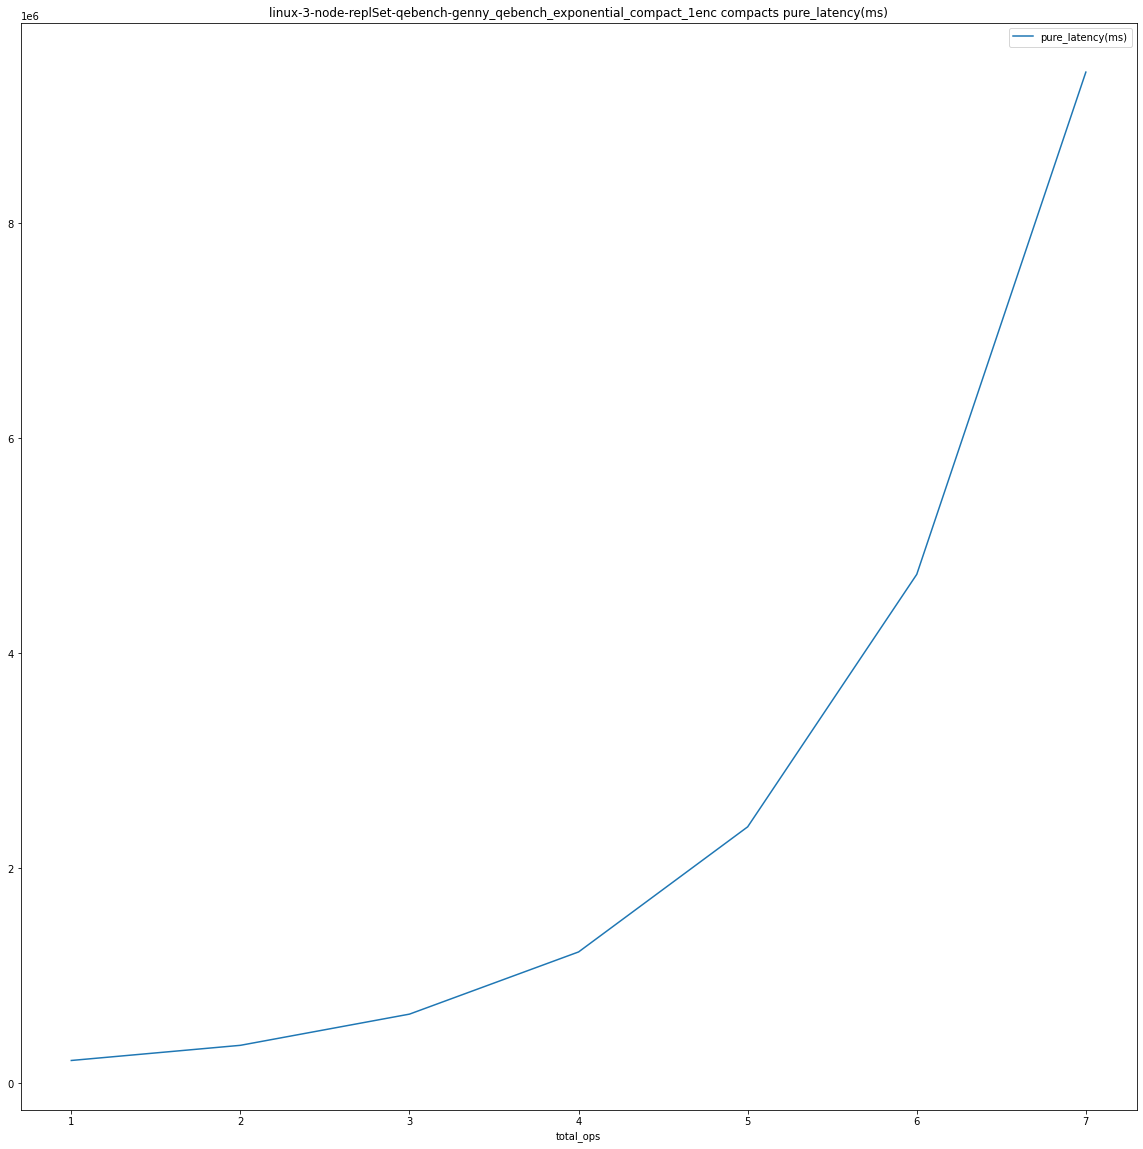

In [6]:
for task, wld in replset_wlds.items():
    wld.plot_compact_data(y=col_latency, x=row, line=True)
    wld.print_compact_summary_statistics()